In [ ]:
!kaggle datasets download -d timoboz/tesla-stock-data-from-2010-to-2020

  0% 0.00/46.1k [00:00<?, ?B/s]
100% 46.1k/46.1k [00:00<00:00, 16.9MB/s]


In [ ]:
!unzip /content/tesla-stock-data-from-2010-to-2020.zip -d data

Archive:  /content/tesla-stock-data-from-2010-to-2020.zip
  inflating: data/TSLA.csv           


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import sklearn
from sklearn.preprocessing import MinMaxScaler

keras = tf.keras

In [ ]:
#creating the dataset

input_path = pd.read_csv('/content/data/TSLA.csv')

In [ ]:
# Getting some info first. Checking if the data is clean
#input_path.info()

# Let't turn the Date object into a Datetime format
input_path['Date'] = pd.to_datetime(input_path['Date'])

input_path.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2416 non-null   datetime64[ns]
 1   Open       2416 non-null   float64       
 2   High       2416 non-null   float64       
 3   Low        2416 non-null   float64       
 4   Close      2416 non-null   float64       
 5   Adj Close  2416 non-null   float64       
 6   Volume     2416 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 132.2 KB


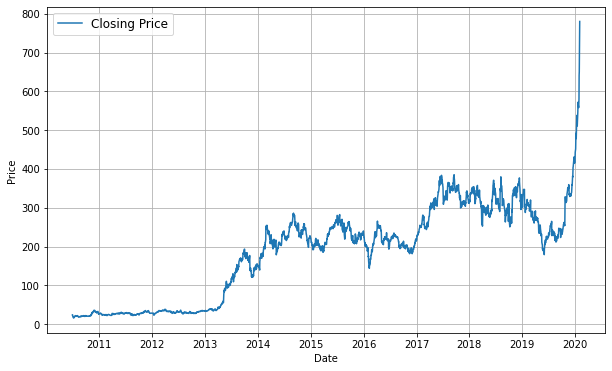

In [ ]:
#Let's quickly define a function to plot the graph
def plot_series(time, series, label):
  plt.plot(time, series, label = label)
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.grid(True)
  if label:
    plt.legend(fontsize = 12)

plt.figure(figsize = (10,6))
plot_series(input_path['Date'], input_path['Close'], 'Closing Price')


In [ ]:
split_time = 1930 # Will be using this number to split the training and validation data (80%, 20%) respectively.
series = input_path['Close']
time = input_path['Date']

x_train = series.iloc[:split_time]
time_train = time.iloc[:split_time]
x_valid = series.iloc[split_time:]
time_valid = time.iloc[split_time:]

Forecasting using ML, we first need to create some windows (datasets of the dataset) and turning them into tensors. Sequence-to-sequence RNN usually works well in that case.

In [ ]:
def window_dataset(series, window_size, batch_size = 32, shuffle_buffer = 1000):
  ds = tf.expand_dims(series, axis = -1) # RNN takes only a 3D input shape. Thus we need to add an extra dimension.
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
  ds = ds.flat_map(lambda window: window.batch(window_size + 1))
  ds = ds.map(lambda x: (x[:-1], x[-1:]))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.batch(32).prefetch(1)
  return ds

Now, deep learning works best with numpy arrays. We should then convert our two series into 2D numpy arrays.

In [ ]:
x_train_np = x_train.to_numpy()
x_train_np = x_train_np.reshape(-1, 1)
x_valid_np = x_valid.to_numpy()
x_valid_np = x_valid_np.reshape(-1, 1)
series_np = series.to_numpy()
series_np = series_np.reshape(-1, 1)

print(series_np.shape)
print(x_train_np.shape)
print(x_valid_np.shape)

(2416, 1)
(1930, 1)
(486, 1)


Now, Let's normalize our data. Since we have a large range of values, normalizing our data will help the model train faster and be more stable. We should also reduce the risk of the vanishing gradient problem.

In [ ]:
scaler = MinMaxScaler()

x_train_np_n = scaler.fit_transform(x_train_np)
x_valid_np_n = scaler.fit_transform(x_valid_np)
series_np_n = scaler.fit_transform(series_np)

In [ ]:
print(series_np_n)

[[0.01058623]
 [0.01050772]
 [0.00806072]
 ...
 [0.81786181]
 [0.83063335]
 [1.        ]]


In [ ]:
window_size = 10
training_set = window_dataset(x_train_np_n, window_size, batch_size = 30) # Will be our training set for training the model
validation_set = window_dataset(x_valid_np_n, window_size, batch_size = 30) #Will be our validation set for training the model

In [ ]:
model = tf.keras.models.Sequential([
   tf.keras.layers.SimpleRNN(100, return_sequences = True, input_shape = [None, 1]),
   tf.keras.layers.SimpleRNN(100, return_sequences = True),
   tf.keras.layers.Dense(1)
   
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch/25))
optimizer = tf.keras.optimizers.SGD(lr = 1e-7, momentum = 0.9)
model.compile(optimizer = optimizer,
              loss = tf.keras.losses.Huber(),
              metrics = ['mae'])
history = model.fit(training_set, epochs = 135, callbacks = [lr_schedule])

Epoch 1/135
60/60 [==============================] - 1s 9ms/step - loss: 0.0637 - mae: 0.2532
Epoch 2/135
60/60 [==============================] - 1s 8ms/step - loss: 0.0635 - mae: 0.2526
Epoch 3/135
60/60 [==============================] - 1s 9ms/step - loss: 0.0633 - mae: 0.2519
Epoch 4/135
60/60 [==============================] - 0s 8ms/step - loss: 0.0631 - mae: 0.2512
Epoch 5/135
60/60 [==============================] - 1s 9ms/step - loss: 0.0629 - mae: 0.2504
Epoch 6/135
60/60 [==============================] - 1s 8ms/step - loss: 0.0627 - mae: 0.2496
Epoch 7/135
60/60 [==============================] - 0s 8ms/step - loss: 0.0624 - mae: 0.2487
Epoch 8/135
60/60 [==============================] - 1s 9ms/step - loss: 0.0622 - mae: 0.2478
Epoch 9/135
60/60 [==============================] - 0s 8ms/step - loss: 0.0619 - mae: 0.2468
Epoch 10/135
60/60 [==============================] - 1s 9ms/step - loss: 0.0615 - mae: 0.2457
Epoch 11/135
60/60 [==============================] - 0s 8m

(1e-07, 0.01, 0.0, 0.05)

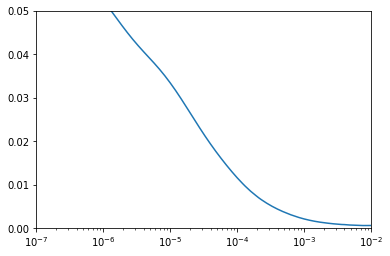

In [ ]:
plt.semilogx(history.history['lr'], history.history['loss']) # Let's now see what our learning rate should be
plt.axis([1e-7, 1e-2, 0, 0.05])

Based on the previous graph, lr = 1e-2 looks quite stable. Let's set it for the model

In [ ]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
   tf.keras.layers.SimpleRNN(100, return_sequences = True, input_shape = [None, 1]),
   tf.keras.layers.SimpleRNN(100, return_sequences = True),
   tf.keras.layers.Dense(1)
   
])

optimizer = tf.keras.optimizers.SGD(lr = 1e-2, momentum = 0.9)
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 15)
model.compile(optimizer = optimizer,
              loss = tf.keras.losses.Huber(),
              metrics = ['mae'])
history = model.fit(training_set, epochs = 300, validation_data = validation_set, callbacks = [early_stopping])

Epoch 1/300
60/60 [==============================] - 1s 15ms/step - loss: 0.0048 - mae: 0.0688 - val_loss: 0.0020 - val_mae: 0.0490
Epoch 2/300
60/60 [==============================] - 1s 9ms/step - loss: 0.0010 - mae: 0.0335 - val_loss: 0.0013 - val_mae: 0.0379
Epoch 3/300
60/60 [==============================] - 1s 10ms/step - loss: 7.0744e-04 - mae: 0.0272 - val_loss: 0.0011 - val_mae: 0.0346
Epoch 4/300
60/60 [==============================] - 1s 10ms/step - loss: 6.5090e-04 - mae: 0.0260 - val_loss: 0.0011 - val_mae: 0.0342
Epoch 5/300
60/60 [==============================] - 1s 9ms/step - loss: 6.0295e-04 - mae: 0.0247 - val_loss: 0.0011 - val_mae: 0.0349
Epoch 6/300
60/60 [==============================] - 1s 10ms/step - loss: 5.6663e-04 - mae: 0.0235 - val_loss: 0.0012 - val_mae: 0.0358
Epoch 7/300
60/60 [==============================] - 1s 10ms/step - loss: 5.6338e-04 - mae: 0.0234 - val_loss: 0.0013 - val_mae: 0.0382
Epoch 8/300
60/60 [==============================] - 1s 10

Let's define our forecast model

In [ ]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift = 1, drop_remainder = True)
  ds = ds.flat_map(lambda window: window.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

Now let's forecast!

In [ ]:
rnn_forecast = model_forecast(model, series_np_n[split_time - window_size: - 1], window_size)[:,0]
print(rnn_forecast.shape)
rnn_forecast = scaler.inverse_transform(rnn_forecast)[:,0] # Reversing normalization to better interpret our results!

(486, 1)


Visualization:

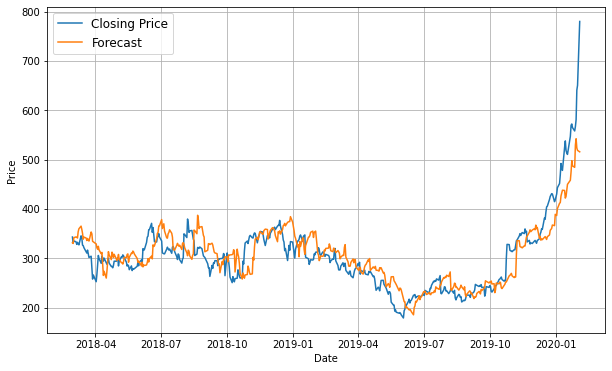

In [ ]:

plt.figure(figsize = (10,6))
plot_series(time_valid, x_valid_np, 'Closing Price')
plot_series(time_valid, rnn_forecast, 'Forecast')

In [ ]:
x_valid_np = x_valid_np[:,0]
tf.keras.metrics.mean_absolute_error(x_valid_np, rnn_forecast).numpy()

27.938135

Let's now try with preprocessing the data with a 1D-Convolutional layer!

In [ ]:
keras.backend.clear_session()

model = keras.models.Sequential([
   keras.layers.Conv1D(filters = 30,
                       kernel_size = 5,
                       strides = 1,
                       padding = 'causal',
                       activation = 'relu',
                       input_shape = [None, 1]),
   keras.layers.LSTM(32, return_sequences = True),
   keras.layers.LSTM(32, return_sequences = True),

   keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10 ** (epoch/25))
optimizer = keras.optimizers.SGD(lr = 1e-7, momentum = 0.9)

model.compile(optimizer = optimizer,
              loss = keras.losses.Huber(),
              metrics = ['mae'])
history = model.fit(training_set, epochs = 150, callbacks = [lr_schedule])

Epoch 1/150
60/60 [==============================] - 1s 10ms/step - loss: 0.1242 - mae: 0.3937
Epoch 2/150
60/60 [==============================] - 1s 10ms/step - loss: 0.1242 - mae: 0.3936
Epoch 3/150
60/60 [==============================] - 1s 11ms/step - loss: 0.1242 - mae: 0.3936
Epoch 4/150
60/60 [==============================] - 1s 10ms/step - loss: 0.1241 - mae: 0.3935
Epoch 5/150
60/60 [==============================] - 1s 11ms/step - loss: 0.1241 - mae: 0.3934
Epoch 6/150
60/60 [==============================] - 1s 11ms/step - loss: 0.1241 - mae: 0.3933
Epoch 7/150
60/60 [==============================] - 1s 11ms/step - loss: 0.1240 - mae: 0.3933
Epoch 8/150
60/60 [==============================] - 1s 11ms/step - loss: 0.1240 - mae: 0.3932
Epoch 9/150
60/60 [==============================] - 1s 11ms/step - loss: 0.1240 - mae: 0.3931
Epoch 10/150
60/60 [==============================] - 1s 11ms/step - loss: 0.1239 - mae: 0.3929
Epoch 11/150
60/60 [=============================

(1e-07, 0.1, 0.0, 0.2)

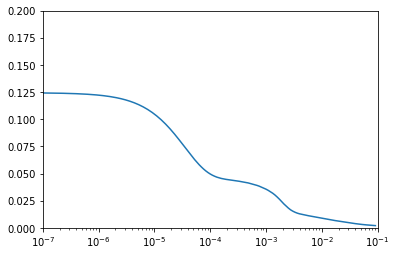

In [ ]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-7, 1e-1, 0, 0.2])

In [ ]:
keras.backend.clear_session()

model = keras.models.Sequential([
   keras.layers.Conv1D(filters = 30,
                       kernel_size = 5,
                       strides = 1,
                       padding = 'causal',
                       activation = 'relu',
                       input_shape = [None, 1]),
   keras.layers.LSTM(32, return_sequences = True),
   keras.layers.LSTM(32, return_sequences = True),

   keras.layers.Dense(1)
])

early_stopping = keras.callbacks.EarlyStopping(patience = 15)
optimizer = keras.optimizers.SGD(lr = 1e-1, momentum = 0.9)

model.compile(optimizer = optimizer,
              loss = keras.losses.Huber(),
              metrics = ['mae'])
history = model.fit(training_set, epochs = 300, validation_data = validation_set, callbacks = [early_stopping])

Epoch 1/300
60/60 [==============================] - 1s 25ms/step - loss: 0.0209 - mae: 0.1615 - val_loss: 0.0147 - val_mae: 0.1357
Epoch 2/300
60/60 [==============================] - 1s 13ms/step - loss: 0.0096 - mae: 0.0997 - val_loss: 0.0077 - val_mae: 0.0993
Epoch 3/300
60/60 [==============================] - 1s 13ms/step - loss: 0.0068 - mae: 0.0809 - val_loss: 0.0050 - val_mae: 0.0783
Epoch 4/300
60/60 [==============================] - 1s 13ms/step - loss: 0.0053 - mae: 0.0683 - val_loss: 0.0040 - val_mae: 0.0668
Epoch 5/300
60/60 [==============================] - 1s 13ms/step - loss: 0.0043 - mae: 0.0599 - val_loss: 0.0032 - val_mae: 0.0567
Epoch 6/300
60/60 [==============================] - 1s 13ms/step - loss: 0.0036 - mae: 0.0542 - val_loss: 0.0029 - val_mae: 0.0533
Epoch 7/300
60/60 [==============================] - 1s 13ms/step - loss: 0.0031 - mae: 0.0514 - val_loss: 0.0027 - val_mae: 0.0520
Epoch 8/300
60/60 [==============================] - 1s 14ms/step - loss: 0.

Let's forecast this new model

In [ ]:
rnn_forecast = model_forecast(model, series_np_n[split_time - window_size - 10:-1], window_size)[:,0]
print(rnn_forecast.shape)
rnn_forecast = scaler.inverse_transform(rnn_forecast)[:,0]

(496, 1)


In [ ]:
def moving_avg(series, window_size):
  mov = np.cumsum(series)
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size - 1: - 1] / window_size

mov_avg = moving_avg(rnn_forecast, 10)
mov_avg.shape

(486,)

Let's check it out!!

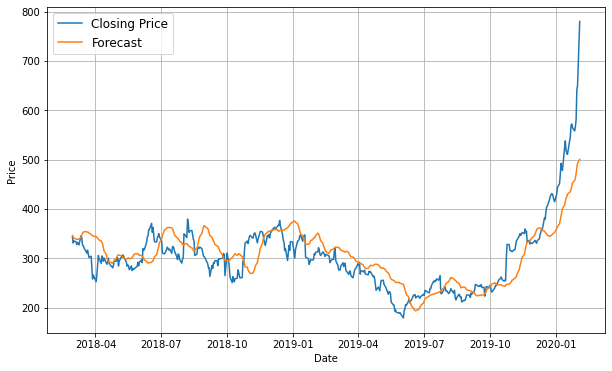

In [ ]:
plt.figure(figsize = (10,6))
plot_series(time_valid, x_valid_np, 'Closing Price')
plot_series(time_valid, mov_avg, 'Forecast')

In [ ]:
keras.metrics.mean_absolute_error(x_valid_np, mov_avg).numpy()

32.751266